In [1]:
import plotly.express as px
import numpy as np
import pandas as pd
# import plotly.graph_objects as go

In [83]:
#Load initial data
dat = pd.read_csv('Covid19_Data.csv', index_col = 0)
dat.index = pd.to_datetime(dat.index)

In [84]:
#Housekeeping to make into multiindex.
col = dat.columns.str.split('_', expand=True)
dat.columns = col
dat.index = dat.index.rename("Date")
dat.columns = dat.columns.rename(['Country', 'Col'])
dat = dat.stack(level=0)
dat.index = dat.index.reorder_levels(['Country', 'Date'])

In [85]:
jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
jhu_df = pd.read_csv(jhu_url, error_bad_lines = False)

jhu_df = jhu_df.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1)
jhu_df = jhu_df.stack().rename('Confirmed').to_frame()


# jhu_df
jhu_df.index = jhu_df.index.rename(['Country', 'Date'])
jhu_df.index = jhu_df.index.set_levels([jhu_df.index.levels[0], pd.to_datetime(jhu_df.index.levels[1])])

jhu_death_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
jhu_death_df = pd.read_csv(jhu_death_url, error_bad_lines = False)

jhu_death_df = jhu_death_df.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1)
jhu_death_df = jhu_death_df.stack().rename('Dead').to_frame()

jhu_death_df.index = jhu_death_df.index.rename(['Country', 'Date'])
jhu_death_df.index = jhu_death_df.index.set_levels([jhu_death_df.index.levels[0], pd.to_datetime(jhu_death_df.index.levels[1])])

jhu_df = jhu_death_df.join(jhu_df)
jhu_death_df = None

# jhu_df.index = jhu_df.index.reorder_levels(["Date", "Country"])
# jhu_df
# jhu_df.loc['Panama'], dat.loc['Panama']['Confirmed']

In [86]:
# dat.unstack().join(jhu_df.unstack(), rsuffix = '_JHU')
# dat.join(jhu_df, rsuffix = '_JHU')
# pd.concat([dat, jhu_df], axis=1 , join = 'inner' )
dat = pd.merge(dat, jhu_df, left_index=True, right_index=True, how = 'outer', suffixes = ('', '_JHU'))
dat['Confirmed'] = dat['Confirmed'].combine_first(dat['Confirmed_JHU'])
dat['Dead'] = dat['Dead'].combine_first(dat['Dead_JHU'])

dat = dat.drop(['Confirmed_JHU', 'Dead_JHU'], axis=1)
# dat.unstack()

In [87]:
def get_divide_cols_fn(c1, c2, res):
    def f(df):
        df[res] = df[c1]/df[c2]
        return df
    return f

# def get_d():
#     def f(df):
        

## TODO:
#### Stats to Add:
* Death Rate
* Hospitalization Rate
* Per capita testing (probably have to include as a separate graph bc x-axis)

#### Other things todo:
* Add lockdown date in graphs (maybe a star)
* Refresh data button? Should just run the data_clean script.


In [88]:
#Add New Cases, New Tests
dat['NewCases'] = dat.groupby('Country')['Confirmed'].diff()
dat['NewTests'] = dat.groupby('Country')['TotalTests'].diff()
# dat['DaysSinceFirst'] = dat.groupby('Country')['Confirmed'].cumcount() + 1
dat['DaysSinceFirst'] = (dat['Confirmed'] >= 1).groupby('Country').cumsum().replace(0, np.nan) - 1
dat['ConfirmedGrowth'] = dat.groupby('Country')['Confirmed'].pct_change() * 100.
dat['DaysSinceTenthDeath'] = (dat['Dead'] >= 10).groupby('Country').cumsum().replace(0, np.nan)
# dat['DaysSinceShutdown'] = dat['Shutdown'].groupby('Country').fillna(method='ffill').groupby('Country').cumsum().replace(0, np.nan) - 1



dat = dat.groupby('Country').apply(get_divide_cols_fn("NewCases", "NewTests", "DailyPosTestRate"))
dat = dat.groupby('Country').apply(get_divide_cols_fn("Confirmed", "TotalTests", "CumulativePosTestRate"))
dat = dat.groupby('Country').apply(get_divide_cols_fn("Dead", "Confirmed", "CumulativeDeadRate"))
# dat['DaysSince'] = dat.groupby('Country')['Confirmed'].expanding(1).count()
# dat['DailyPosTestRate'] = dat.groupby(level=1)['NewCases']/dat.groupby(level=1)['NewTests']




In [89]:
dat['DaysSinceShutdown'] = np.nan
x = (dat[dat['Shutdown'] == 1]).groupby('Country').shift(0)
s_countries = list(x.index.get_level_values(0))

for s in s_countries:
    #Find d
    old = x.xs(s, level=0)
    d = (old.index[x['Shutdown'] == 1] - dat.index[0][1]).days[0]
    new = dat.xs(s, level=0).Shutdown.shift(-d+2).fillna(1).cumsum() - (d-1)
    dat.loc[s]['DaysSinceShutdown'] = new

In [90]:
# dat.loc['Peru']['DaysSinceShutdown'].tail(15)
dat = dat[dat['Confirmed'] >= 1]
# s_countries

In [91]:
dat.tail(10)

dat = dat.set_index([dat.index, "DaysSinceFirst", "DaysSinceTenthDeath", "DaysSinceShutdown"
                    ]).reorder_levels(["Country", "DaysSinceFirst", "DaysSinceTenthDeath", "DaysSinceShutdown",
                                       "Date"]).sort_index()

In [92]:
dat.tail(30)

countries = list(dat.index.get_level_values(0).unique())
stats = list(dat.columns)
stat_map = {
    'DailyPosTestRate': 'Daily Positive Test Rate',
    'Confirmed': 'Confirmed Tests',
    'NewTests': 'Daily New Tests',
    'CumulativePosTestRate': 'Cumulative Positive Test Rate',
    'NewCases': 'New Cases',
    'TotalTests': 'Total Tests',
    'ConfirmedGrowth': 'Daily Confirmed Cases Growth (%)',
    'CumulativeDeadRate': 'Cumulative Death Rate'
}

xs = ['DaysSinceFirst', 'Date', 'DaysSinceTenthDeath', 'DaysSinceShutdown']
xs_map = {'DaysSinceFirst': 'Days Since First Confirmed',
         'DaysSinceTenthDeath': 'Days Since 10th Death',
         'DaysSinceShutdown': 'Days Since Economic Shutdown'}


# Important Dates by Country:

### Peru
- Sourhces: ministerio de salud, wikipedia page
* March 11 - Declaran emergencia sanitaria por 90 dias
* March 13 - Suspenden vuelos internacional desde Europa y Asia
* March 16 - Teletrabajo para todos menos los esenciales
* March 17 - Cierran fronteras
* March 18 - Cuarentena general entre 8PM y 5 AM.
* https://www.dge.gob.pe/portal/

### Panama
* Something

### Guatemala
- Source: Alejandro Giammattei twitter
* March 22 - Cuarentena general entre 4 PM y 4 AM por 8 dias

In [95]:
def make_graph(count_to_plot, stat_to_plot, x_axis, plot_style = 0, m=None):
    to_add = ['Date'] if x_axis != 'Date' else []
    to_plot = dat.reset_index()
    to_plot = to_plot[to_plot.Country.isin(count_to_plot)][['Country'] + [stat_to_plot] + [x_axis] + ['Shutdown']+to_add ]
    if x_axis != 'Date':
        to_plot['Date'] = to_plot['Date'].dt.strftime('%b %d, %Y')
#     to_plot.Shutdown = to_plot.Shutdown.fillna(method  = 'ffill')
    to_plot.Shutdown = to_plot.Shutdown.fillna(value = 0)
    
#     to_plot = to_plot.dropna(axis=0, how = 'any')
    print(to_plot.head())

    
    if plot_style == 0:
        fig = px.scatter(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         hover_data = ['Date'] if x_axis != 'Date' else [],
#                          symbol = 'Shutdown',
#                          symbol_map = {1: 'star', 0:'circle'},
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
    elif plot_style == 1:
        fig = px.bar(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         barmode = 'group',
                         hover_data = ['Date'] if x_axis != 'Date' else [],
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
    elif plot_style == 2:
        fig = px.line(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         hover_data = ['Date'] if x_axis != 'Date' else [],
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
#     fig.add_trace(tr)
    
#     fig.update_xaxes(title = 'Days Since First Confirmed Test')
    fig.update_xaxes(title = xs_map.get(x_axis, x_axis))
    fig.update_yaxes(title = stat_to_plot)
    
#     for trace in fig.data:
#         trace.name = trace.name.split(',')[0]
    
    if m is not None:
        x_lim = to_plot.reset_index().groupby('Country')[x_axis].max().min() * m
        y_lim = to_plot.reset_index().groupby('Country')[stat_to_plot].max().min() * m
        fig.update_xaxes(range = [0, x_lim])
        fig.update_yaxes(range = [0, y_lim])
        
    return fig



    Country  Confirmed  DaysSinceShutdown  Shutdown          Date
765   China      548.0                NaN       0.0  Jan 22, 2020
766   China      643.0                NaN       0.0  Jan 23, 2020
767   China      920.0                NaN       0.0  Jan 24, 2020
768   China     1406.0                NaN       0.0  Jan 25, 2020
769   China     2075.0                NaN       0.0  Jan 26, 2020


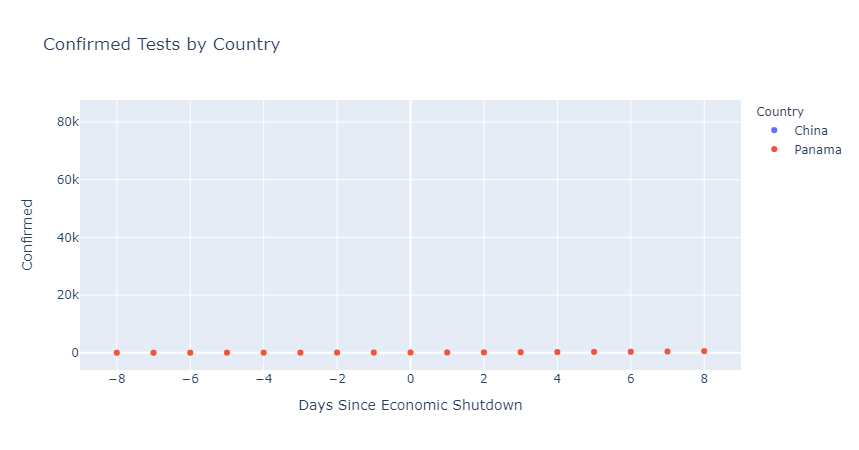

In [97]:
count_to_plot = ['Panama', 'China']
y_to_plot =  'Confirmed'
x_lab = 'DaysSinceShutdown'
x_axis = x_lab
stat_to_plot = y_to_plot
f = make_graph(count_to_plot, y_to_plot, x_lab, plot_style=0)
f

In [35]:
to_add = ['Date'] if x_axis != 'Date' else []
to_plot = dat.reset_index()
to_plot = to_plot[to_plot.Country.isin(count_to_plot)][['Country'] + [stat_to_plot] + [x_axis] + ['Shutdown']+to_add ]
if x_axis != 'Date':
    to_plot['Date'] = to_plot['Date'].dt.strftime('%b %d, %Y')
# print(to_plot)
to_plot.Shutdown = to_plot.Shutdown.fillna(value = 0)
to_plot

,Country,Confirmed,DaysSinceShutdown,Shutdown,Date
7873,Panama,1.0,NaN,0.0,"Mar 09, 2020"
7874,Panama,8.0,NaN,0.0,"Mar 10, 2020"
7875,Panama,14.0,NaN,0.0,"Mar 11, 2020"
7876,Panama,27.0,NaN,0.0,"Mar 12, 2020"
7877,Panama,36.0,NaN,0.0,"Mar 13, 2020"
...,...,...,...,...,...
8124,Peru,0.0,NaN,0.0,"Mar 01, 2020"
8125,Peru,0.0,NaN,0.0,"Mar 02, 2020"
8126,Peru,0.0,NaN,0.0,"Mar 03, 2020"
8127,Peru,0.0,NaN,0.0,"Mar 04, 2020"


In [81]:
fill_val = dat.index.get_level_values('DaysSinceShutdown')
fill_val

Float64Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              ...
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
             dtype='float64', name='DaysSinceShutdown', length=11137)

In [36]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from jupyter_plotly_dash import JupyterDash
# import jupyterlab_dash

In [37]:
# viewer = jupyterlab_dash.AppViewer()
# app = dash.Dash('Covid-Tracking')
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash('Covid-Tracking')

In [38]:
app.layout = html.Div([
    html.Div([
        html.H2('COVID-19 Tracking',)
    ]),
    html.Div([    
        html.P(["Countries:", 
            dcc.Dropdown(
                id = 'country-select',
    #             options = countries,
                options = [{'label': stat_map.get(c, c), 'value': c} for c in countries],
                value = ['Panama'],
                multi = True
            )
        ]),
    ], style = {"width": "30%", 'display': 'inline-block', 'text-align': 'center'} ),
    html.Div([
        html.P(["Statistics:",
            dcc.Dropdown(
                id = 'statistic-select',
                options = [{'label': stat_map.get(s, s), 'value': s} for s in stats],
                value = ['Confirmed'],
                multi=True
            )
        ])
    ], style = {'width':'30%', 'display':'inline-block', 'text-align': 'center'}),
    html.Div([
        html.P(["X-Axis:",
            dcc.Dropdown(
                id = 'x-axis-select',
                options = [{'label': xs_map.get(x, x), 'value': x} for x in xs],
                value = 'DaysSinceFirst',
                multi=False
            )
        ])
    ], style = {'width':'20%', 'display':'inline-block', 'text-align': 'center'}),
    html.Div([
        html.P(["Graph Style:",
            dcc.Dropdown(
                id = 'graph-style',
                options = [{'label': 'Scatter', 'value': 0}, 
                           {'label': 'Bar' , 'value': 1},
                           {'label': 'Line', 'value': 2}],
                value = 0,
                multi=False
            )
        ])
    ], style = {'width':'20%', 'display':'inline-block', 'text-align': 'center'}),
    
    html.Div(children = html.Div(id='graphs'), className = 'row', style = {"display":'inline-block', 'width': '100%'}),

    html.Div([
        html.P(['Most data on confirms and deaths from Johns Hopkins. Panama, Peru, South Korea testing data independently gathered.']),
    ])
#     dcc.Graph(id='graphs', style = {'width': '80%', 'display': 'inline-block'}),
], className = 'container'
)


@app.callback(
    dash.dependencies.Output('graphs', 'children'),
    [dash.dependencies.Input('country-select', 'value'), dash.dependencies.Input('statistic-select', 'value'),
    dash.dependencies.Input('x-axis-select', 'value'), dash.dependencies.Input('graph-style', 'value')]
)
def update_graph(countries, stats, x_axis, graph_style):
    if len(stats)>2:
        class_choice = 'col s12 m6 l4'
    elif len(stats) == 2:
        class_choice = 'col s12 m6 l6'
    else:
        class_choice = 'col s12'
    #Returns a list of graphs
    graphs = []
#     return make_graph(countries, stats[0], scatter=False)
    for plot_stat in stats:
        g = make_graph(countries, plot_stat, x_axis, plot_style=graph_style)
        graphs.append(html.Div(dcc.Graph(
            id = plot_stat,
            animate = True,
            figure = g        
            ), className = class_choice
        ))
    return graphs
# viewer.show(app)

In [39]:
app

In [33]:
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary'